# Imports

In [1]:
import sys
import os
import torch
import torch_directml
import pandas as pd
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import json
from nltk.tokenize import word_tokenize
import numpy as np
import re
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

/home/kolton/miniconda3/envs/pydml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [2]:
def get_bert_embedding(text, tokenizer, model, device, max_length):
    # Tokenize the text
    tokens = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=max_length).to(device)

    # Get BERT model outputs
    with torch.no_grad():
        outputs = model(**tokens)
        last_hidden_states = outputs.last_hidden_state

        # Average pooling to get a fixed-size embedding
        pooled_embedding = torch.mean(last_hidden_states, dim=1)

    # Move the tensor to CPU and convert to NumPy array
    return pooled_embedding.cpu().squeeze().tolist()
    #return pooled_embedding.cpu().numpy()

In [3]:
def get_stopwords(stopwords_dir):
    '''
    gets all stopwords located in files located in stopwords_dir
    '''
    files = os.listdir(stopwords_dir)
    
    stopwords = []
    for file in files:
        if os.path.isfile(stopwords_dir + file):
            with open(stopwords_dir + file) as f:
                stopwords += f.readlines()
                
    return set([word.strip() for word in stopwords])

In [4]:
def preprocess(text):
    '''
    Preprocess given text with following steps:
    -word tokenize the text (NLTK's word_tokenize)
    -remove stopwords as outlined previously
    '''
    stopwords = get_stopwords('../Data/stopwords/')
    
    tokens = word_tokenize(text)
    tokens = [word.strip().lower() for word in tokens if word.lower() not in stopwords]
    tokens = [word for word in tokens if not (word.isdigit() or (word.replace('.', '', 1).isdigit() and '.' in word))]
    tokens = [word for word in tokens if re.match('^[a-zA-Z0-9/]*$', word)]
    
    return ' '.join(tokens)

In [73]:
def plot_pca(data, labels, n_components=2, ax=None, title='', remove={}):
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(data)

    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['LABEL'] = labels
    pca_df.sort_values(by='LABEL', inplace=True, ascending=False)

    if remove:
        pca_df = pca_df[pca_df[remove['col']] < remove['val']]
    
    # Plot the data points with different colors for each label
    colors = {'ARF': 'red', 'OTHER': 'gray'}

    if not ax:
        fig, ax = plt.subplots()
    
    for label, color in colors.items():
        if label == 'ARF':
            opacity = .7
            zorder = 2
        else:
            opacity = .5
            zorder = 1
        subset = pca_df[pca_df['LABEL'] == label]
        ax.scatter(subset['PC1'], subset['PC2'], c=color, label=label, alpha=opacity, zorder=zorder)
    
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(title)
    ax.legend()

In [114]:
def plot_tsne(data, labels, n_components=2, ax=None, title='', n_iter=1500, lr=1000, perplexity=20, remove={}):
    data = np.array(data)
    
    tsne = TSNE(n_components=n_components,
                perplexity=perplexity,
                random_state=6, 
                learning_rate=lr,
                n_iter=n_iter,
                verbose=0)
    
    tsne_results = tsne.fit_transform(data)
    
    df_tsne = pd.DataFrame(data=tsne_results, columns=['TSNE1', 'TSNE2'])
    df_tsne['LABEL'] = df.LABEL.to_list()

    if remove:
        df_tsne = df_tsne[df_tsne[remove['col']] < remove['val']]
    
    # Plot the t-SNE results
    colors = {'ARF': 'red', 'OTHER': 'gray'}

    if not ax:
        fig, ax = plt.subplots()
    
    for label, color in colors.items():
        if label == 'ARF':
            opacity = .8
            zorder = 2
        else:
            opacity = .6
            zorder = 1
        subset = df_tsne[df_tsne['LABEL'] == label]
        ax.scatter(subset['TSNE1'], subset['TSNE2'], c=color, label=label, alpha=opacity, zorder=zorder, marker='o', edgecolor='w')
    
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_title(title)
    ax.legend()

# Setup

In [6]:
# Read in the data
df = pd.read_csv('../Data/all_notes_raw.csv')

with open('../Data/arf_hadm_ids.json', 'r') as j_file:
    arf_hadm_ids = json.load(j_file)

with open('../Data/other_hadm_ids.json', 'r') as j_file:
    other_hadm_ids = json.load(j_file)

arf_rows = df[df.HADM_ID.isin(arf_hadm_ids)]
arf_rows['LABEL'] = 'ARF'
other_rows = df[~df.HADM_ID.isin(arf_hadm_ids)]
other_rows['LABEL'] = 'OTHER'
random_seed = 21
other_sampled_rows = other_rows.sample(50, replace=False, random_state=random_seed)
df = pd.concat([arf_rows, other_sampled_rows])
df['TEXT'] = df['TEXT'].astype(str)
df['TEXT'] = df['TEXT'].str.lower()

tqdm.pandas()
df['PROCESSED_TEXT'] =  df['TEXT'].progress_apply(preprocess)

/tmp/ipykernel_726/998395749.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arf_rows['LABEL'] = 'ARF'
/tmp/ipykernel_726/998395749.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other_rows['LABEL'] = 'OTHER'
100%|█████████████████████████████████████████████████████████████████████████████████| 326/326 [00:13<00:00, 23.81it/s]


# Token Counts 

In [126]:
all_counts = Counter()
arf_counts = Counter()
other_counts = Counter()

for i, row in df.iterrows():
    curr_text = row['PROCESSED_TEXT'].split(' ')
    
    if row['LABEL'] == 'ARF':
        arf_counts.update(curr_text)
    else:
        other_counts.update(curr_text)
    all_counts.update(curr_text)

print(f'''
Len all counts: {len(all_counts)}
Len ARF counts: {len(arf_counts)}
Len Other counts: {len(other_counts)}
''')

all_tokens = all_counts.keys()
all_token_counts = all_counts.values()

arf_token_counts = [arf_counts[token] for token in all_tokens]
other_token_counts = [other_counts[token] for token in all_tokens]

count_data = pd.DataFrame({'Tokens': all_tokens, 'Total': all_token_counts, 'ARF': arf_token_counts, 'Other': other_token_counts})
count_data['Percentage_ARF'] = round(count_data['ARF'] / count_data['Total'], 2)
count_data = count_data.sort_values(by='Total', ascending=False)


Len all counts: 27634
Len ARF counts: 23129
Len Other counts: 13149



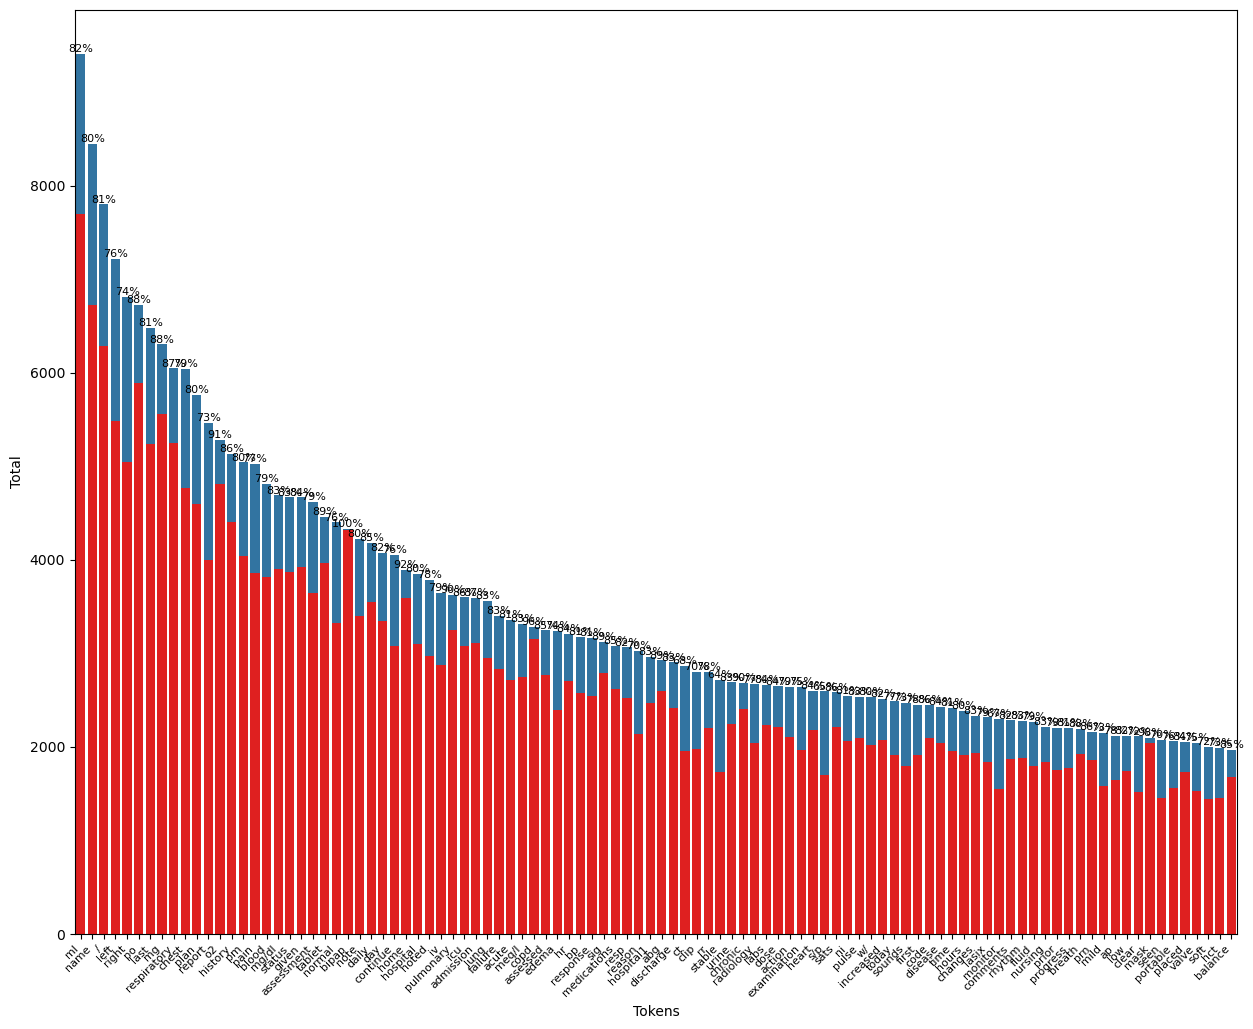

In [56]:
fig, subfigs = plt.subplots(figsize=(15, 12))

subset = count_data.head(100)

sns.barplot(data=subset, x='Tokens', y='Total', ax=subfigs)
sns.barplot(data=subset, x='Tokens', y='ARF', color='red', ax=subfigs)

total_ = subset['Total'].to_list()
percentage_ = subset['Percentage_ARF'].to_list()
for i, val in enumerate(percentage_):
    subfigs.text(i, total_[i], f'{int(val*100)}%', ha='center', va='bottom', fontsize=8)

subfigs.set_xticks(subfigs.get_xticks())
subfigs.set_xticklabels(labels=subset.Tokens, rotation=45, fontsize=8, ha='right');

# BERT Embeddings

In [57]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
max_length = 512

#model_name = 'medicalai/ClinicalBERT'
#tokenizer = AutoTokenizer.from_pretrained(model_name)
#model = AutoModel.from_pretrained(model_name)

# Get GPU device
try:
    device = torch_directml.device()
    model.to(device)
except:
    print('Putting model on dml failed. Try putting on cpu instead')

In [58]:
tqdm.pandas()
df['BERT_EMBEDDINGS'] = list(df['PROCESSED_TEXT'].progress_apply((lambda x: get_bert_embedding(x, tokenizer, model, device, max_length))))
df.head()

100%|█████████████████████████████████████████████████████████████████████████████████| 326/326 [00:42<00:00,  7.67it/s]


,HADM_ID,TEXT,LABEL,PROCESSED_TEXT,BERT_EMBEDDINGS
81,100124,----category:discharge summary----\n\n--new:re...,ARF,category discharge summary report admission da...,"[-0.37669166922569275, 0.2685607075691223, 0.3..."
139,100220,----category:discharge summary----\n\n--new:re...,ARF,category discharge summary report admission da...,"[-0.31648582220077515, 0.336014062166214, 0.52..."
334,100557,----category:discharge summary----\n\n--new:re...,ARF,category discharge summary report admission da...,"[-0.30875566601753235, 0.21054646372795105, 0...."
395,100660,----category:discharge summary----\n\n--new:re...,ARF,category discharge summary report admission da...,"[-0.3353317081928253, 0.1933441460132599, 0.51..."
567,100933,----category:discharge summary----\n\n--new:re...,ARF,category discharge summary report admission da...,"[-0.4786178171634674, 0.2181847095489502, 0.36..."


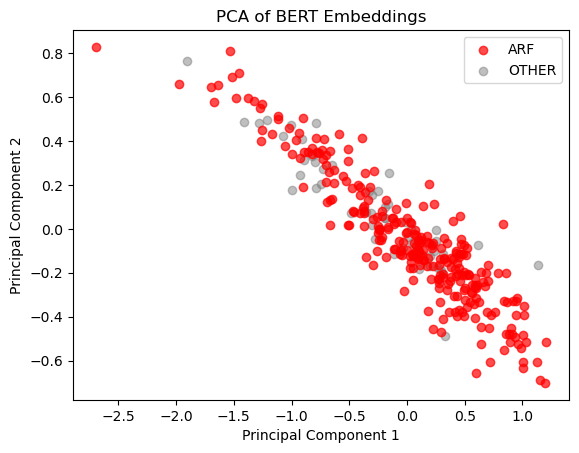

In [74]:
plot_pca(df.BERT_EMBEDDINGS.to_list(), df.LABEL.to_list(), title='PCA of BERT Embeddings', remove={'col': 'PC1', 'val': 2})

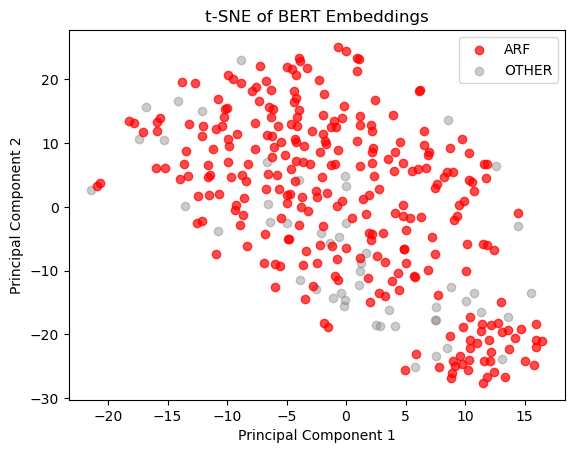

In [100]:
plot_tsne(df.BERT_EMBEDDINGS.to_list(), df.LABEL.to_list(), title='t-SNE of BERT Embeddings', #remove={'col': 'TSNE1', 'val': 2000},
         perplexity=20,
         n_iter=1000,
         lr=100)

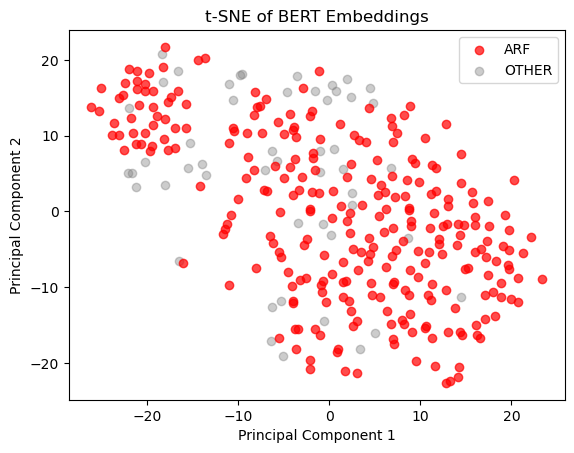

In [101]:
# Number of principal components (you can adjust this)
n_components = 50

# Perform PCA
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(df.BERT_EMBEDDINGS.to_list())


plot_tsne(principal_components, df.LABEL.to_list(), title='t-SNE of BERT Embeddings', #remove={'col': 'TSNE1', 'val': 2000},
         perplexity=20,
         n_iter=1000,
         lr=100)

# TF-IDF

In [102]:
corpus = df.PROCESSED_TEXT.to_list()

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(corpus)

feature_names = vectorizer.get_feature_names_out()

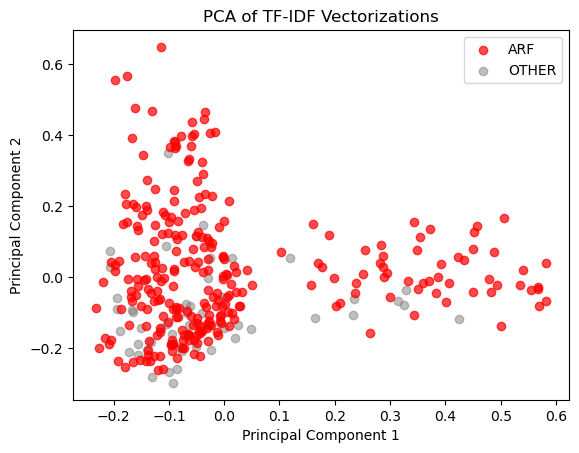

In [106]:
plot_pca(tfidf_matrix.toarray(), df.LABEL.to_list(), title='PCA of TF-IDF Vectorizations', remove={'col': 'PC1', 'val': 2})

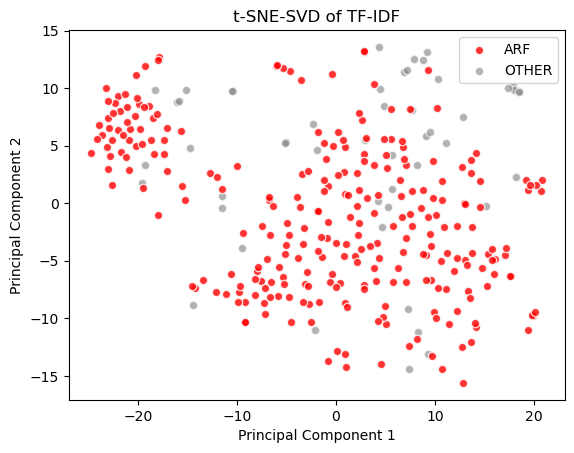

In [115]:
svd = TruncatedSVD(n_components=50)
tfidf_svd = svd.fit_transform(tfidf_matrix)

plot_tsne(tfidf_svd, df.LABEL.to_list(), title='t-SNE-SVD of TF-IDF', #remove={'col': 'TSNE1', 'val': 2000},
         perplexity=30,
         n_iter=1000,
         lr='auto')

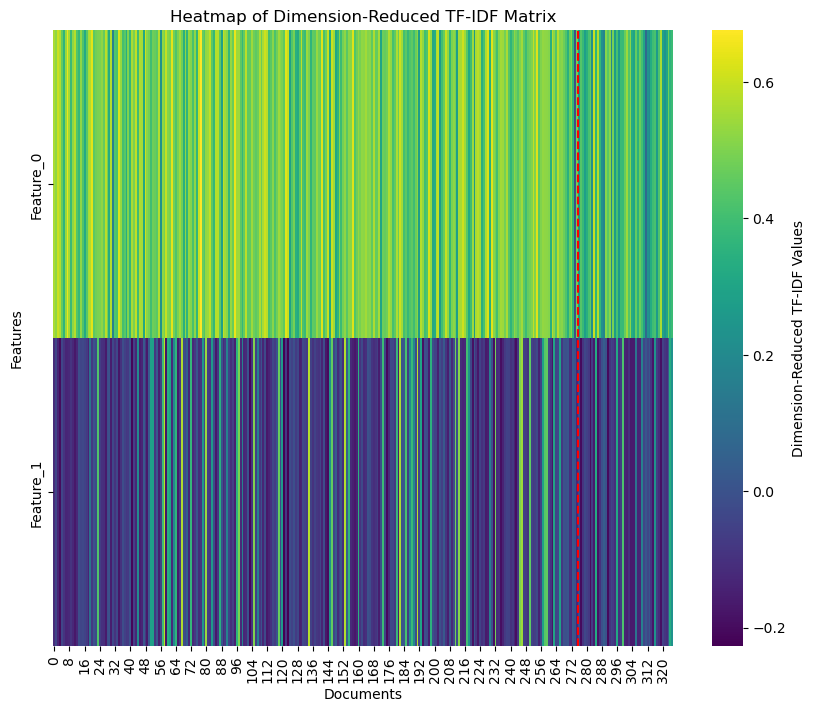

In [148]:
n_components = 2
svd = TruncatedSVD(n_components=n_components)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)

# Create a DataFrame with the reduced TF-IDF matrix
df_tfidf_reduced = pd.DataFrame(tfidf_matrix_reduced, columns=[f'Feature_{i}' for i in range(n_components)])
#df_tfidf_reduced['LABEL'] = df['LABEL'].to_list()
#df_tfidf_reduced.sort_values(by='LABEL')

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_tfidf_reduced.transpose(), cmap='viridis', cbar_kws={'label': 'Dimension-Reduced TF-IDF Values'})
plt.xlabel('Documents')
plt.ylabel('Features')
plt.title('Heatmap of Dimension-Reduced TF-IDF Matrix')


# Highlight cells corresponding to specific labels
#plt.annotate('ARF', xy=(276, 0), ha='center', va='center', color='red', fontsize=8, rotation=45)
plt.axvline(x=276, color='red', linestyle='--')


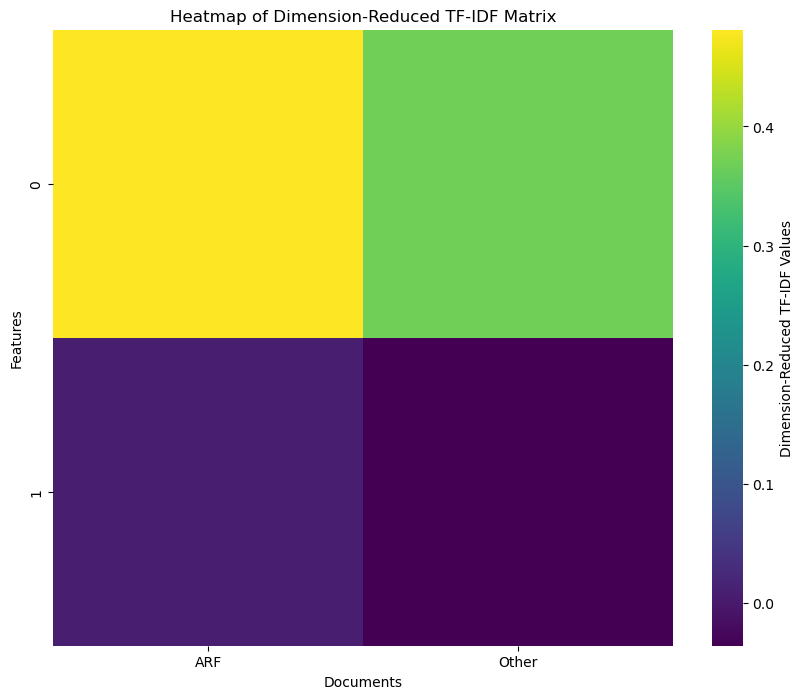

In [153]:
feat1_arf = df_tfidf_reduced.iloc[:276]['Feature_0'].mean()
feat2_arf = df_tfidf_reduced.iloc[:276]['Feature_1'].mean()

feat1_other = df_tfidf_reduced.iloc[276:]['Feature_0'].mean()
feat2_other = df_tfidf_reduced.iloc[276:]['Feature_1'].mean()

averaged_tfidf_reduced = pd.DataFrame({'ARF': [feat1_arf, feat2_arf], 'Other': [feat1_other, feat2_other]})

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(averaged_tfidf_reduced, cmap='viridis', cbar_kws={'label': 'Dimension-Reduced TF-IDF Values'})
plt.xlabel('Documents')
plt.ylabel('Features')
plt.title('Heatmap of Averaged Dimension-Reduced TF-IDF Matrix')

Text(0.5, 1.0, 'Scatter Plot of Dimension-Reduced TF-IDF Values with Annotations')

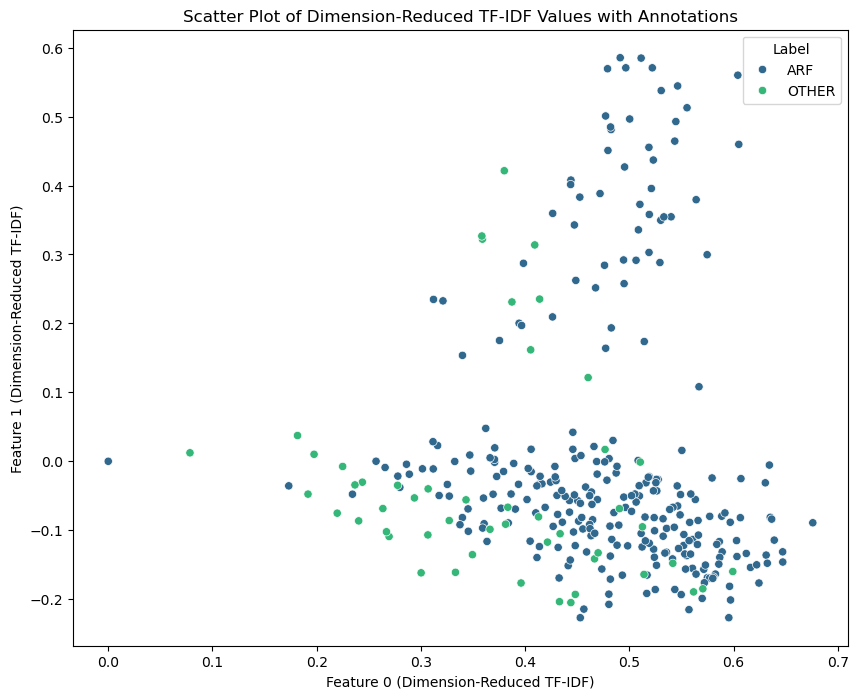

In [155]:
df_tfidf_reduced['Label'] = labels

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Feature_0', y='Feature_1', hue='Label', data=df_tfidf_reduced, palette='viridis')

# Annotate the points with document indices
#for i, label in enumerate(labels):
#    plt.annotate(i, (df_tfidf_reduced['Feature_0'][i], df_tfidf_reduced['Feature_1'][i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

# Set labels and title
plt.xlabel('Feature 0 (Dimension-Reduced TF-IDF)')
plt.ylabel('Feature 1 (Dimension-Reduced TF-IDF)')
plt.title('Scatter Plot of Dimension-Reduced TF-IDF Values with Annotations')